# Introduction

TBD


In [1]:
warmup_2015 = 1
epochs_2015 = 3
warmup_2019 = 1
epochs_2019 = 5
lr_decay = 0
warmup_enabled = True
batch_size = 32
model_img_size = 448
tta = True
n_classes = 5
resnet_depth = 20
resnet_version = 1

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import PIL
from PIL import ImageOps
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras

from tqdm.auto import tqdm
tqdm.pandas()

Using TensorFlow backend.


In [3]:
!ls -l ../input/

total 8
drwxr-xr-x 4 root root 4096 Jun 28 02:06 aptos2019-blindness-detection
drwxr-xr-x 3 root root 4096 Jul  1 02:43 retinopathy-train-2015


## Number of files in train vs test vs the 2015 training set

In [4]:
!ls -l ../input/aptos2019-blindness-detection/train_images | wc -l

3663


In [5]:
!ls -l ../input/aptos2019-blindness-detection/test_images | wc -l

1929


In [6]:
!ls -l ../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896 | wc -l

35127


## Basic metadata

In [7]:
train_path_2015 = "../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896/"
train_path_2019 = "../input/aptos2019-blindness-detection/train_images/"
test_path_2019 = "../input/aptos2019-blindness-detection/test_images/"


In [8]:
df_train_2019 = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
df_train_2019.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [9]:
df_test_2019 = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
df_test_2019.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [10]:
df_train_2015 = pd.read_csv("../input/retinopathy-train-2015/rescaled_train_896/trainLabels.csv")
df_train_2015.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Collect all metadata to single dataframe(s)

In [11]:
n_rows_2019 = df_train_2019.shape[0]
n_rows_2019

3662

In [12]:
df_train_2019["filename"] = df_train_2019["id_code"]+".png"
df_train_2019["path"] = [train_path_2019]*n_rows_2019
#the year is just to be able to easily separate the past and present datasets later
df_train_2019["year"] = [2019]*n_rows_2019
df_train_2019.head()

,id_code,diagnosis,filename,path,year
0,000c1434d8d7,2,000c1434d8d7.png,../input/aptos2019-blindness-detection/train_i...,2019
1,001639a390f0,4,001639a390f0.png,../input/aptos2019-blindness-detection/train_i...,2019
2,0024cdab0c1e,1,0024cdab0c1e.png,../input/aptos2019-blindness-detection/train_i...,2019
3,002c21358ce6,0,002c21358ce6.png,../input/aptos2019-blindness-detection/train_i...,2019
4,005b95c28852,0,005b95c28852.png,../input/aptos2019-blindness-detection/train_i...,2019


In [13]:
n_rows_2015 = df_train_2015.shape[0]
n_rows_2015

35126

In [14]:
df_train_2015["filename"] = df_train_2015["image"]+".png"
df_train_2015["path"] = [train_path_2015]*n_rows_2015
df_train_2015["year"] = [2015]*n_rows_2015
df_train_2015.head()

,image,level,filename,path,year
0,10_left,0,10_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
1,10_right,0,10_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
2,13_left,0,13_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
3,13_right,0,13_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
4,15_left,1,15_left.png,../input/retinopathy-train-2015/rescaled_train...,2015


In [15]:
n_rows_test = df_test_2019.shape[0]
n_rows_test

1928

In [16]:
df_test_2019.columns

Index(['id_code'], dtype='object')

In [17]:
df_test_2019["filename"] = df_test_2019["id_code"]+".png"
df_test_2019["path"] = [test_path_2019]*n_rows_test
df_test_2019["year"] = [2050]*n_rows_test
df_test_2019["diagnosis"] = -1
df_test_2019 = df_test_2019[["id_code", "diagnosis", "filename", "path", "year"]]
df_test_2019.head()

,id_code,diagnosis,filename,path,year
0,0005cfc8afb6,-1,0005cfc8afb6.png,../input/aptos2019-blindness-detection/test_im...,2050
1,003f0afdcd15,-1,003f0afdcd15.png,../input/aptos2019-blindness-detection/test_im...,2050
2,006efc72b638,-1,006efc72b638.png,../input/aptos2019-blindness-detection/test_im...,2050
3,00836aaacf06,-1,00836aaacf06.png,../input/aptos2019-blindness-detection/test_im...,2050
4,009245722fa4,-1,009245722fa4.png,../input/aptos2019-blindness-detection/test_im...,2050


In [18]:
df_train_2015.columns = ["id_code", "diagnosis", "filename", "path", "year"]
df_train_2015.head()

,id_code,diagnosis,filename,path,year
0,10_left,0,10_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
1,10_right,0,10_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
2,13_left,0,13_left.png,../input/retinopathy-train-2015/rescaled_train...,2015
3,13_right,0,13_right.png,../input/retinopathy-train-2015/rescaled_train...,2015
4,15_left,1,15_left.png,../input/retinopathy-train-2015/rescaled_train...,2015


In [19]:
df_train_all = pd.concat([df_train_2019,df_train_2015, df_test_2019], axis=0, sort=False).reset_index()
df_train_all.head()

,index,id_code,diagnosis,filename,path,year
0,0,000c1434d8d7,2,000c1434d8d7.png,../input/aptos2019-blindness-detection/train_i...,2019
1,1,001639a390f0,4,001639a390f0.png,../input/aptos2019-blindness-detection/train_i...,2019
2,2,0024cdab0c1e,1,0024cdab0c1e.png,../input/aptos2019-blindness-detection/train_i...,2019
3,3,002c21358ce6,0,002c21358ce6.png,../input/aptos2019-blindness-detection/train_i...,2019
4,4,005b95c28852,0,005b95c28852.png,../input/aptos2019-blindness-detection/train_i...,2019


In [20]:
df_train_all.tail()

,index,id_code,diagnosis,filename,path,year
40711,1923,ff2fd94448de,-1,ff2fd94448de.png,../input/aptos2019-blindness-detection/test_im...,2050
40712,1924,ff4c945d9b17,-1,ff4c945d9b17.png,../input/aptos2019-blindness-detection/test_im...,2050
40713,1925,ff64897ac0d8,-1,ff64897ac0d8.png,../input/aptos2019-blindness-detection/test_im...,2050
40714,1926,ffa73465b705,-1,ffa73465b705.png,../input/aptos2019-blindness-detection/test_im...,2050
40715,1927,ffdc2152d455,-1,ffdc2152d455.png,../input/aptos2019-blindness-detection/test_im...,2050


In [21]:
#replacing df_train with the full set to calculate features and do visualizations all at once, keeping the original (present) just in case
df_train = df_train_all

## Calculate Aspect Ratios etc.

In [22]:
%%time
img_sizes = []
widths = []
heights = []
aspect_ratios = []

for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    filename = row["filename"]
    path = row["path"]
    img_path = os.path.join(path, filename)
    with open(img_path, 'rb') as f:
        img = PIL.Image.open(f)
        img_size = img.size
        img_sizes.append(img_size)
        widths.append(img_size[0])
        heights.append(img_size[1])
        aspect_ratios.append(img_size[0]/img_size[1])

df_train["width"] = widths
df_train["height"] = heights
df_train["aspect_ratio"] = aspect_ratios
df_train["size"] = img_sizes


CPU times: user 16.2 s, sys: 16.3 s, total: 32.6 s
Wall time: 1min 40s


In [23]:
df_train.head()

,index,id_code,diagnosis,filename,path,year,width,height,aspect_ratio,size
0,0,000c1434d8d7,2,000c1434d8d7.png,../input/aptos2019-blindness-detection/train_i...,2019,3216,2136,1.505618,"(3216, 2136)"
1,1,001639a390f0,4,001639a390f0.png,../input/aptos2019-blindness-detection/train_i...,2019,3216,2136,1.505618,"(3216, 2136)"
2,2,0024cdab0c1e,1,0024cdab0c1e.png,../input/aptos2019-blindness-detection/train_i...,2019,2416,1736,1.391705,"(2416, 1736)"
3,3,002c21358ce6,0,002c21358ce6.png,../input/aptos2019-blindness-detection/train_i...,2019,1050,1050,1.000000,"(1050, 1050)"
4,4,005b95c28852,0,005b95c28852.png,../input/aptos2019-blindness-detection/train_i...,2019,2048,1536,1.333333,"(2048, 1536)"


In [24]:
df_train_2019 = df_train[df_train["year"] == 2019]
df_train_2015 = df_train[df_train["year"] == 2015]
df_test = df_train[df_train["year"] == 2050]

In [25]:
#This just shows a single image in the notebook
def show_img(filename, path):
        img = PIL.Image.open(f"{path}/{filename}")
        npa = np.array(img)
        print(npa.shape)
        #https://stackoverflow.com/questions/35902302/discarding-alpha-channel-from-images-stored-as-numpy-arrays
#        npa3 = npa[ :, :, :3]
        print(filename)
        plt.imshow(npa)


In [26]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [27]:
def load_ben_color(data, img_size, sigmaX=10):
    if data.ndim == 4:  # array of images
        for i in range(len(data)):
            image = cv2.cvtColor(data[i], cv2.COLOR_BGR2RGB)
            image = crop_image_from_gray(image)
            image = cv2.resize(image, (img_size, img_size))
            data[i] = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 ,128)
    elif data.ndim == 3:  # just a single image
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        data = crop_image_from_gray(data)
        data = cv2.resize(data, (img_size, img_size))
        data = cv2.addWeighted(data, 4, cv2.GaussianBlur(data, (0,0), sigmaX), -4 , 128)
    else: 
        return 0
    
    return data

In [28]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [29]:
def image_preprocessing(data, img_size, sigmaX=10):
    # cropping & Ben Graham's preprocessing method
    data = load_ben_color(data, img_size, sigmaX)
    
    # normalization (rescaling between 0 and 1)
    data = data.astype('float32')
    for i in range(len(data)):
        cv2.normalize(data[i],  data[i], 0, 1, cv2.NORM_MINMAX)
        
    return data

In [30]:
from imgaug import augmenters as iaa

def img_augment(img):
    img = load_ben_color(img, model_img_size, 10)
    #fifty_chance = lambda aug: iaa.Sometimes(0.5, aug)
    import random
    if random.randint(1,101) > 90:
        #print("original")
        #one in 10 return original image
        return img
    seq = iaa.SomeOf(3, [
        iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        #iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 1.0 TODO: test for good values
        iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            scale=(0.8, 1.2),
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": 0}, # translate by -20 to +20 percent (per axis)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            rotate=(-10, 10), # rotate by -10 to +10 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        iaa.Affine(
            shear=(-5, 5), # shear by -5 to +5 degrees
            #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode="constant" # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
    ])
    img = seq.augment_image(img)
    return img

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
#https://github.com/aleju/imgaug

In [31]:
from keras.applications import resnet50
import random

def img_pad_resize(df, filename, input_path, augment):
    img_meta = df[df["filename"] == filename].iloc[0]
    #print(img_meta)
    img = PIL.Image.open(f'{input_path}/{filename}')

    cropped = False
    if random.randint(1,101) > 50:
        aspect_ratio = img_meta["aspect_ratio"]
        if aspect_ratio > 2 or aspect_ratio < 0.5:
            img_w = img_meta["width"]
            img_h = img_meta["height"]
            diff = abs(img_w-img_h)
            if img_w > img_h:
                shorter = "height"
                larger = "width"
                crop_y = 0
                crop_x = random.randint(0, diff)
            else:
                shorter = "width"
                larger = "height"
                crop_x = 0
                crop_y = random.randint(0, diff)
            crop_size = img_meta[shorter]
            img_cropped = img.crop((crop_x, crop_y, crop_x+crop_size, crop_y+crop_size))
            img.close()
            img = img_cropped
            cropped = True
            #print("cropped:"+filename)
       
    w = img.size[0]
    h = img.size[1]
    pad_size = np.abs(h-w)
    wm = hm = 1
    pw = ph = 0
    if w < h:
        wm = h / w
        pw = pad_size / 2
    else:
        hm = w / h
        ph = pad_size / 2
    w *= wm
    h *= hm
    h = int(h)
    w = int(w)
    pw = int(pw)
    ph = int(ph)
    padding = (pw, ph, pw, ph)
    padded = ImageOps.expand(img, padding)
    resized = padded.resize((model_img_size, model_img_size))
    np_img = np.array(resized)
    img.close()
    padded.close()
    del img
    del padded
    if augment:
        np_img = img_augment(np_img)
    #np_img = resnet50.preprocess_input(np_img)
    return np_img

In [32]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a.iloc[p], b[p]

In [33]:
from skimage.io import imread
from skimage.transform import resize
from keras.utils import Sequence

#https://github.com/sdcubber/Keras-Sequence-boilerplate/blob/master/Keras-Sequence.ipynb
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class MySequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, mode="train", augment=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.mode = mode
        self.max_idx = math.ceil(len(x_set)/batch_size)
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx2 = idx % self.max_idx
        #i guess the len method above stops the generator from being called too much
        #print(f"idx:{idx}, idx2:{idx2}")
        start = idx * self.batch_size
        end = min(start + batch_size, len(self.x))
        batch_x = self.x.iloc[start : end]
        batch_y = self.y[start : end]
        
        next_batch = []
        for index, row in batch_x.iterrows():
            file_name = row["filename"]
            file_path = row["path"]
            padded = img_pad_resize(self.x, file_name, file_path, self.augment)
            if padded.shape != (model_img_size, model_img_size, 3):
                print(f"shape mismatch {file_name}, {file_path}, {padded.shape}")
                print()
                #the image has alpha channel, drop it
                padded = padded[ :, :, :3]
            
            next_batch.append(padded)
        np_y = np.array(batch_y)
        result = np.array(next_batch), np_y

        #print(result[0].shape)
        return result

    def on_epoch_end(self):
        self.x, self.y = unison_shuffled_copies(self.x, self.y)


In [34]:
df_train_2015.head()

,index,id_code,diagnosis,filename,path,year,width,height,aspect_ratio,size
3662,0,10_left,0,10_left.png,../input/retinopathy-train-2015/rescaled_train...,2015,896,597,1.500838,"(896, 597)"
3663,1,10_right,0,10_right.png,../input/retinopathy-train-2015/rescaled_train...,2015,896,597,1.500838,"(896, 597)"
3664,2,13_left,0,13_left.png,../input/retinopathy-train-2015/rescaled_train...,2015,896,672,1.333333,"(896, 672)"
3665,3,13_right,0,13_right.png,../input/retinopathy-train-2015/rescaled_train...,2015,896,672,1.333333,"(896, 672)"
3666,4,15_left,1,15_left.png,../input/retinopathy-train-2015/rescaled_train...,2015,896,593,1.510961,"(896, 593)"


In [35]:
y_2015 = df_train_2015["diagnosis"]
y_2019 = df_train_2019["diagnosis"]

In [36]:
y_2015 = np.zeros((n_rows_2015, n_classes))
idx = 0
for diagnosis in df_train_2015["diagnosis"]:
    y_2015[idx][int(diagnosis)] = 1
    idx += 1

In [37]:
y_2019 = np.zeros((n_rows_2019, n_classes))
idx = 0
for diagnosis in df_train_2019["diagnosis"]:
    y_2019[idx][int(diagnosis)] = 1
    idx += 1

In [38]:
from sklearn.model_selection import train_test_split

def create_generators(df_train, y):
    indexes = np.arange(df_train.shape[0])
    train_indices, valid_indices = train_test_split(indexes, test_size=0.10, random_state=8, stratify=y)
    train_sub_df = df_train.iloc[train_indices]
    train_sub_y = y[train_indices]
    valid_sub_df = df_train.iloc[valid_indices]
    valid_sub_y = y[valid_indices]
    warmup_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=False)
    train_gen = MySequence(train_sub_df, train_sub_y, batch_size, augment=True)
    valid_gen = MySequence(valid_sub_df, valid_sub_y, batch_size, augment=False)
    return train_indices, valid_indices, warmup_gen, train_gen, valid_gen

In [39]:
train_indices_2015, valid_indices_2015, warmup_gen_2015, train_gen_2015, valid_gen_2015 = create_generators(df_train_2015, y_2015)

In [40]:
train_indices_2019, valid_indices_2019, warmup_gen_2019, train_gen_2019, valid_gen_2019 = create_generators(df_train_2019, y_2019)

from sklearn.model_selection import train_test_split

#https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
indexes = np.arange(df_train_2015.shape[0])
train_indices, valid_indices = train_test_split(indexes, test_size=0.10, random_state=8, stratify=y_2015)

train_sub_df = df_train_2015.iloc[train_indices]
train_sub_y = y_2015[train_indices]
valid_sub_df = df_train_2015.iloc[valid_indices]
valid_sub_y = y_2015[valid_indices]
#train_gen = MySequence(train_sub_df, train_sub_df["breed_label"], batch_size)
#valid_gen = MySequence(valid_sub_df, valid_sub_df["breed_label"], batch_size)
warmup_gen_2015 = MySequence(train_sub_df, train_sub_y, batch_size, augment=False)
#TODO: remove probability of no augment from generator?
train_gen_2015 = MySequence(train_sub_df, train_sub_y, batch_size, augment=True)
valid_gen_2015 = MySequence(valid_sub_df, valid_sub_y, batch_size, augment=False)

In [41]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
checkpoint = ModelCheckpoint('../working/Resnet20_best_{epoch:03d}_{val_loss:.2f}.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=7)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

callbacks_list = [checkpoint, csv_logger, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [42]:
def plot_gen_batch(idx):
    # configure batch size and retrieve one batch of images
    plt.clf() #clears matplotlib data and axes
    #for batch in train_generator:
    rows = (batch_size / 3)+1
    plt.figure(figsize=[30,10*rows])
    batch = train_gen_2019.__getitem__(idx)
    for x in range(0,batch_size-1):
    #    print(train_generator.filenames[x])
        plt.subplot(rows, 3, x+1)
        plt.imshow(batch[0][x], interpolation='nearest')

        diagnosis = batch[1][x]
        print(diagnosis)

    plt.show()

In [43]:
#plot_gen_batch(0)

In [44]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [45]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [46]:
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, AveragePooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from keras.applications.resnet50 import ResNet50

def create_model(trainable_layer_count):
    input_tensor = Input(shape=(model_img_size, model_img_size, 3))
    base_model = ResNet50(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    if load_weights:
        base_model.load_weights('../input/retinopathy_weights/resnet50_best.h5')

#    base_model = ResNet50(include_top=False,
#                          #the weights value can apparently also be a file path..
#                   weights=None, #loading weights from dataset, avoiding need for internet conn
#                   input_tensor=input_tensor)
#    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    if trainable_layer_count == "all":
        for layer in base_model.layers:
            layer.trainable = True
    else:
        for layer in base_model.layers:
            layer.trainable = False
        for layer in base_model.layers[-trainable_layer_count:]:
            layer.trainable = True
    print("base model has {} layers".format(len(base_model.layers)))
#     x = Conv2D(32, kernel_size=(1,1), activation='relu')(base_model.output)
#     x = Flatten()(x)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(5e-4))(x)
    x = Dropout(0.5)(x)
    #predict individual probability of each category
    final_output = Dense(n_classes, activation='softmax', name='final_output')(x)
#    final_output = Dense(n_classes, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)

    return model


In [47]:
#model = create_model(train_depth)
input_shape = (model_img_size, model_img_size, 3)
depth = resnet_depth
if resnet_version == 1:
    model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=5)
else:
    model = resnet_v2(input_shape=input_shape, depth=depth, num_classes=5)
    

In [48]:
from keras.optimizers import Adam
#f2_score = my_f2

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss

In [49]:
#https://gombru.github.io/2018/05/23/cross_entropy_loss/


In [50]:
if warmup_enabled:
    #train_steps = 2*len(train_indices)/batch_size
    #valid_steps = 2*len(valid_indices)/batch_size
    train_steps = len(train_indices_2015)/batch_size
    valid_steps = len(valid_indices_2015)/batch_size
    fit_history = model.fit_generator(
            warmup_gen_2015,
            steps_per_epoch=train_steps,
            epochs = warmup_2015,
            use_multiprocessing=True,
            workers=2,
            callbacks=[], #no callbacks for warmup
        verbose = 1
    )

Epoch 1/1
988/987 [==============================] - 962s 973ms/step - loss: 4.4130 - acc: 0.7336


In [51]:
from keras.optimizers import Adam
#f2_score = my_f2
#https://datascience.stackexchange.com/questions/26112/decay-parameter-in-keras-optimizers
if lr_decay > 0:
    model.compile(optimizer=Adam(lr=0.0001, decay=lr_decay), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss
else:
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss
    


In [52]:
#train_steps = 2*len(train_indices)/batch_size
#valid_steps = 2*len(valid_indices)/batch_size
train_steps = len(train_indices_2015)/batch_size
valid_steps = len(valid_indices_2015)/batch_size
fit_history = model.fit_generator(
        train_gen_2015,
        steps_per_epoch=train_steps,
        epochs = epochs_2015,
        validation_data=valid_gen_2015,
        validation_steps=valid_steps,
        use_multiprocessing=True,
        workers=2,
        callbacks=callbacks_list,
    verbose = 1
)


Epoch 1/3
988/987 [==============================] - 1766s 2s/step - loss: 4.3220 - acc: 0.7348 - val_loss: 4.2949 - val_acc: 0.7347

Epoch 00001: val_loss improved from inf to 4.29488, saving model to ../working/Resnet20_best_001_4.29.h5
Epoch 2/3
988/987 [==============================] - 1711s 2s/step - loss: 4.2856 - acc: 0.7348 - val_loss: 4.2825 - val_acc: 0.7347

Epoch 00002: val_loss improved from 4.29488 to 4.28247, saving model to ../working/Resnet20_best_002_4.28.h5
Epoch 3/3
988/987 [==============================] - 1693s 2s/step - loss: 1.5509 - acc: 0.7259 - val_loss: 0.9381 - val_acc: 0.7347

Epoch 00003: val_loss improved from 4.28247 to 0.93809, saving model to ../working/Resnet20_best_003_0.94.h5


In [53]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss

In [54]:
if warmup_enabled:
    #train_steps = 2*len(train_indices)/batch_size
    #valid_steps = 2*len(valid_indices)/batch_size
    train_steps = len(train_indices_2019)/batch_size
    valid_steps = len(valid_indices_2019)/batch_size
    fit_history = model.fit_generator(
            warmup_gen_2019,
            steps_per_epoch=train_steps,
            epochs = warmup_2019,
            use_multiprocessing=True,
            workers=2,
            callbacks=[], #no callbacks for warmup
        verbose = 1
    )

Epoch 1/1
103/102 [==============================] - 304s 3s/step - loss: 1.2658 - acc: 0.6237


In [55]:
from keras.optimizers import Adam
#https://datascience.stackexchange.com/questions/26112/decay-parameter-in-keras-optimizers
if lr_decay > 0:
    model.compile(optimizer=Adam(lr=0.0001, decay=lr_decay), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss
else:
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"]) #loss=focal_loss
    


In [56]:
#train_steps = 2*len(train_indices)/batch_size
#valid_steps = 2*len(valid_indices)/batch_size
train_steps = len(train_indices_2019)/batch_size
valid_steps = len(valid_indices_2019)/batch_size
fit_history = model.fit_generator(
        train_gen_2019,
        steps_per_epoch=train_steps,
        epochs = epochs_2019,
        validation_data=valid_gen_2019,
        validation_steps=valid_steps,
        use_multiprocessing=True,
        workers=2,
        callbacks=callbacks_list,
    verbose = 1
)


Epoch 1/5
103/102 [==============================] - 434s 4s/step - loss: 1.3892 - acc: 0.5442 - val_loss: 3.6874 - val_acc: 0.3351

Epoch 00001: val_loss did not improve from 0.93809
Epoch 2/5
103/102 [==============================] - 430s 4s/step - loss: 0.9651 - acc: 0.6552 - val_loss: 1.7905 - val_acc: 0.4632

Epoch 00002: val_loss did not improve from 0.93809
Epoch 3/5
103/102 [==============================] - 438s 4s/step - loss: 0.8929 - acc: 0.6865 - val_loss: 2.2210 - val_acc: 0.4278

Epoch 00003: val_loss did not improve from 0.93809
Epoch 4/5
103/102 [==============================] - 450s 4s/step - loss: 0.8422 - acc: 0.7011 - val_loss: 2.1590 - val_acc: 0.4796

Epoch 00004: val_loss did not improve from 0.93809
Epoch 5/5
103/102 [==============================] - 444s 4s/step - loss: 0.8164 - acc: 0.7078 - val_loss: 2.6891 - val_acc: 0.4877

Epoch 00005: val_loss did not improve from 0.93809

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

In [57]:
def plot_loss_and_accuracy(fit_history):
    plt.clf()
    plt.plot(fit_history.history['acc'])
    plt.plot(fit_history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()
    # summarize history for loss
    plt.plot(fit_history.history['loss'])
    plt.plot(fit_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


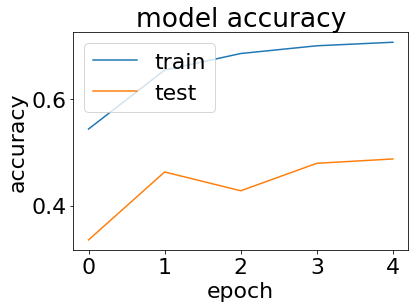

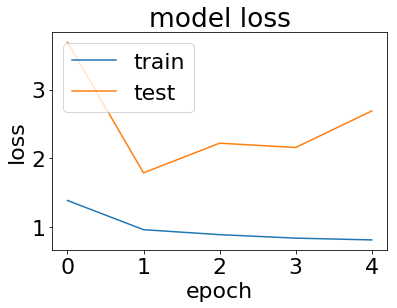

In [58]:
plot_loss_and_accuracy(fit_history)

In [59]:
pd.DataFrame(fit_history.history).head(20)

,val_loss,val_acc,loss,acc,lr
0,3.687380,0.335150,1.389332,0.544158,0.0001
1,1.790485,0.463215,0.965065,0.655235,0.0001
2,2.221013,0.427793,0.892760,0.686495,0.0001
3,2.159013,0.479564,0.842177,0.701062,0.0001
4,2.689073,0.487738,0.816402,0.707739,0.0001


In [60]:
%%time

n_tta = 10

submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
predicted = []

for name in tqdm(submit['id_code']):
    np_img = img_pad_resize(df_test, name+".png", test_path, False)
#    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
#    img = PIL.Image.open(path+".png")
#    resized = img.resize((model_img_size, model_img_size))
#    np_img = np.array(resized)
    if tta:
        img_pred = np.zeros(n_classes)
        for x in range(n_tta):
            aug_img = img_augment(np_img)
            #img_augment already runs resnet50.preprocess_input
            score_predict = model.predict(aug_img[np.newaxis])
            img_pred += np.squeeze(score_predict)
        img_pred /= n_tta
        score_predict = img_pred
    else:
        score_predict = model.predict(resnet50.preprocess_input(np_img[np.newaxis]))
    label_predict = np.argmax(score_predict)
    predicted.append(str(label_predict))

NameError: name 'test_path' is not defined

In [61]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

ValueError: Length of values does not match length of index